In [6]:
import json
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd, YearEnd

In [2]:
data = pd.read_csv('returns.csv', index_col = 0)
data.index = pd.to_datetime(data.index)
data = data[1:]
data.head()

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-03,NaN,0.017936,NaN,NaN,-0.012308,NaN,NaN,NaN,0.005435,0.000000,...,NaN,0.008474,NaN,-0.005971,0.000000,NaN,NaN,NaN,NaN,NaN
1985-01-04,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,...,NaN,-0.008403,NaN,0.000000,-0.005618,NaN,NaN,NaN,NaN,NaN
1985-01-07,NaN,-0.004405,NaN,NaN,0.012461,NaN,NaN,NaN,0.010811,0.020135,...,NaN,0.000000,NaN,-0.006006,0.008474,NaN,NaN,NaN,NaN,NaN
1985-01-08,NaN,-0.008849,NaN,NaN,-0.006154,NaN,NaN,NaN,-0.021390,0.000000,...,NaN,0.000000,NaN,-0.003021,0.000000,NaN,NaN,NaN,NaN,NaN
1985-01-09,NaN,0.026784,NaN,NaN,-0.001872,NaN,NaN,NaN,0.005464,0.000000,...,NaN,-0.004237,NaN,0.006060,0.002801,NaN,NaN,NaN,NaN,NaN


In [3]:
# load FF
ff = pd.read_csv("data/ff_daily.csv")

ff["Date"] = pd.to_datetime(ff["Date"].astype(str), format='%Y%m%d')
ff = ff.set_index("Date")
ff = ff / 100 # convert to percentage
ff

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.0010,-0.0025,-0.0027,0.00009
1926-07-02,0.0045,-0.0033,-0.0006,0.00009
1926-07-06,0.0017,0.0030,-0.0039,0.00009
1926-07-07,0.0009,-0.0058,0.0002,0.00009
1926-07-08,0.0021,-0.0038,0.0019,0.00009
...,...,...,...,...
2024-12-24,0.0111,-0.0009,-0.0005,0.00017
2024-12-26,0.0002,0.0104,-0.0019,0.00017
2024-12-27,-0.0117,-0.0066,0.0056,0.00017


In [4]:
common = data.index.intersection(ff.index)
ff = ff.loc[common]

xreturns = data.subtract(ff['RF'], axis = 0)
xreturns

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-03,NaN,0.017646,NaN,NaN,-0.012598,NaN,NaN,NaN,0.005145,-0.000290,...,NaN,0.008184,NaN,-0.006261,-0.000290,NaN,NaN,NaN,NaN,NaN
1985-01-04,NaN,-0.000290,NaN,NaN,-0.000290,NaN,NaN,NaN,-0.000290,-0.000290,...,NaN,-0.008693,NaN,-0.000290,-0.005908,NaN,NaN,NaN,NaN,NaN
1985-01-07,NaN,-0.004695,NaN,NaN,0.012171,NaN,NaN,NaN,0.010521,0.019845,...,NaN,-0.000290,NaN,-0.006296,0.008184,NaN,NaN,NaN,NaN,NaN
1985-01-08,NaN,-0.009139,NaN,NaN,-0.006444,NaN,NaN,NaN,-0.021680,-0.000290,...,NaN,-0.000290,NaN,-0.003311,-0.000290,NaN,NaN,NaN,NaN,NaN
1985-01-09,NaN,0.026494,NaN,NaN,-0.002162,NaN,NaN,NaN,0.005174,-0.000290,...,NaN,-0.004527,NaN,0.005770,0.002511,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.004324,-0.005758,0.015191,-0.009289,0.004860,-0.004525,0.016134,-0.002526,0.003968,0.007262,...,0.007090,0.007119,-0.003517,0.008404,0.001559,0.008296,-0.000056,0.007395,0.015244,0.001434
2023-12-26,0.001509,-0.003051,-0.002275,-0.014983,0.001624,-0.004679,-0.003088,-0.001028,0.008770,0.012804,...,-0.004375,0.007648,0.006204,0.002851,0.002047,0.008490,0.001790,0.008932,0.022395,0.002457
2023-12-27,-0.000138,0.000308,0.001471,-0.015853,0.004917,0.000198,0.000893,-0.003854,0.002204,-0.003249,...,0.000668,0.003544,-0.004276,-0.003288,-0.004909,0.006479,0.004243,-0.002598,0.000843,0.006951


In [5]:
monthly_dates = data.resample("MS").last().index
monthly_dates

DatetimeIndex(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01',
               '1985-05-01', '1985-06-01', '1985-07-01', '1985-08-01',
               '1985-09-01', '1985-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Date', length=468, freq='MS')

In [13]:
winnerLosers = pd.DataFrame()

for month in monthly_dates[36:]:
    end = month - relativedelta(months = 1) + MonthEnd(0)
    beg = month - relativedelta(months = 36)
    returns36month = data[(data.index >= beg) & (data.index < end)]
    returns36month = returns36month + 1
    cum36 = returns36month.prod() - 1

    winnerLosers[month] = cum36

winnerLosers = winnerLosers.T


/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/897998041.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  winnerLosers[month] = cum36
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/897998041.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  winnerLosers[month] = cum36
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/897998041.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

In [14]:
winnerLosers

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
1988-01-01,0.000000,2.127682,0.000000,0.000000,1.491462,0.000000,0.000000,3.296287,-0.318841,0.991291,...,0.000000,0.505990,0.000000,0.644461,1.071374,0.000000,0.000000,0.000000,0.000000,0.000000
1988-02-01,0.000000,1.876399,0.000000,0.000000,1.182258,0.000000,0.000000,2.925917,-0.448062,0.651133,...,0.000000,0.363551,0.000000,0.733857,1.074703,0.000000,0.000000,0.000000,0.000000,0.000000
1988-03-01,0.000000,2.397311,0.000000,0.000000,1.203470,0.000000,0.000000,3.259252,-0.399399,0.877822,...,0.000000,0.545262,0.000000,0.731674,1.047898,0.000000,0.000000,0.000000,0.000000,0.000000
1988-04-01,0.000000,2.595581,0.000000,0.000000,0.870677,0.000000,0.000000,3.629622,-0.339623,0.702700,...,0.000000,0.572855,0.000000,0.647509,0.959288,0.000000,0.000000,0.000000,0.000000,0.000000
1988-05-01,0.000000,2.885781,0.000000,0.000000,0.890813,0.000000,0.000000,4.185174,0.009009,0.946208,...,0.000000,0.502658,0.000000,0.560299,1.054827,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.333527,0.877093,0.806873,0.059567,0.177084,1.512195,0.463107,0.190291,0.824025,1.162118,...,0.037854,0.383509,0.508044,-0.008911,1.899722,0.597978,0.587896,0.087577,0.065646,0.278222
2023-09-01,0.245013,0.480486,0.760616,-0.097436,0.002272,1.444198,0.404170,0.062272,0.631699,0.928355,...,0.057688,0.247906,0.142130,-0.096642,2.215419,0.336587,0.432741,-0.101606,-0.025896,0.228853
2023-10-01,0.128955,0.505092,0.934644,-0.051828,-0.064832,1.725128,0.416349,0.039700,0.582842,0.734048,...,0.043784,0.235557,0.293203,-0.095414,2.966907,0.120599,0.444486,-0.131983,-0.063099,0.074118
2023-11-01,0.010139,0.592578,0.888721,-0.191832,-0.068184,1.743462,0.406724,0.178573,0.387899,0.650959,...,0.330665,0.202382,0.222057,-0.084910,2.759433,0.060848,0.355726,-0.175665,-0.260436,0.009717


In [15]:
import math

def top10_long_short_equal_weight(row):
    ten_percent = math.floor(len(row) * 0.10)
    top = row.nlargest(ten_percent).index
    bot = row.nsmallest(ten_percent).index
    weight = pd.Series(0, index = row.index)
    weight[top] = -1 / ten_percent
    weight[bot] = 1 / ten_percent
    return weight

def top10_long_equal_weight(row):
    ten_percent = math.floor(len(row) * 0.10)
    bot = row.nsmallest(ten_percent).index
    weight = pd.Series(0, index = row.index)
    weight[bot] = 1 / ten_percent
    return weight

In [16]:
weights_long_short = winnerLosers.apply(top10_long_short_equal_weight, axis = 1)
weights_long = winnerLosers.apply(top10_long_equal_weight, axis = 1)

/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/1681042095.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight[top] = -1 / ten_percent
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/1681042095.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight[top] = -1 / ten_percent
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/1681042095.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight[top] = -1 

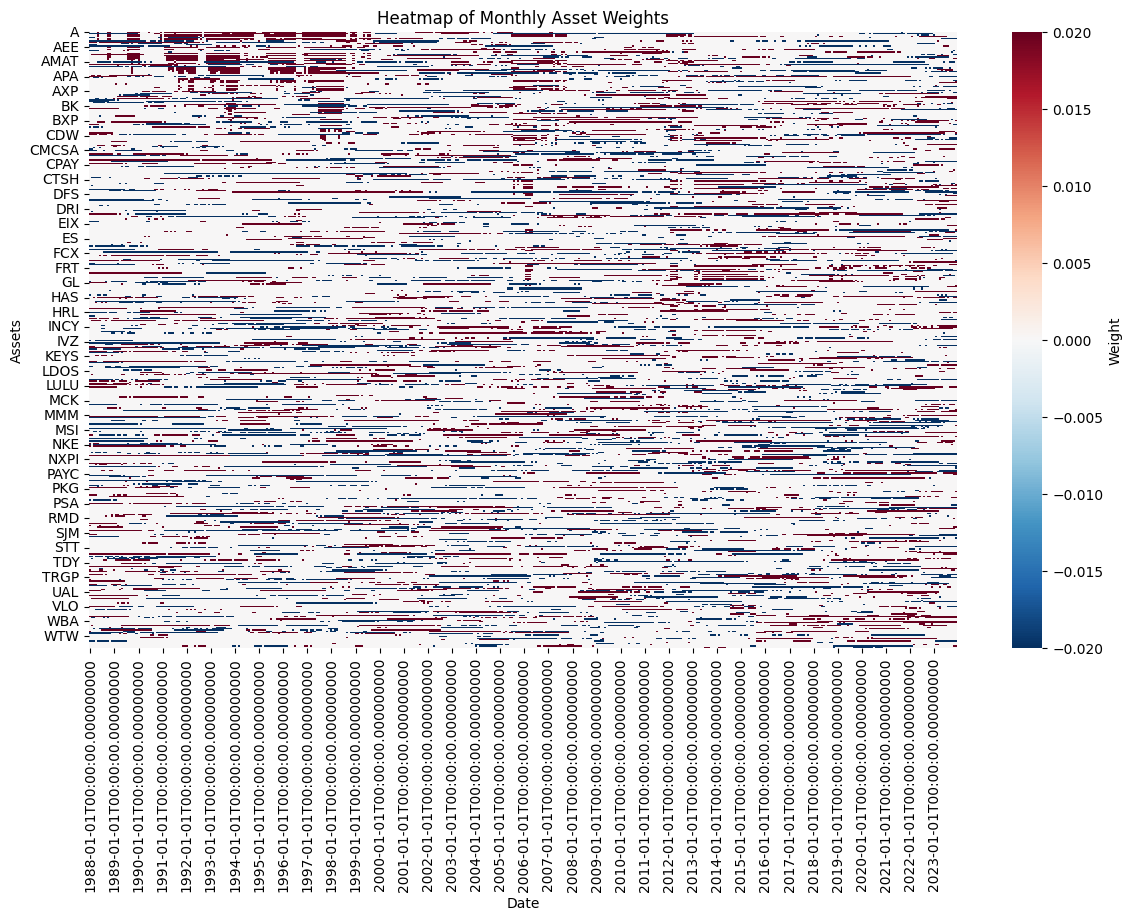

In [17]:

assets = weights_long_short.iloc[0].index

plt.figure(figsize=(14,8))
sns.heatmap(weights_long_short[assets].T,
    cmap='RdBu_r',
    cbar_kws={'label':'Weight'},
    xticklabels=12,
    # yticklabels=False
)
plt.xlabel('Date')
plt.ylabel('Assets')
plt.title('Heatmap of Monthly Asset Weights')
plt.show()



In [18]:
portfolio_long = pd.DataFrame()
portfolio_long_short = pd.DataFrame()

for month in weights_long_short.index:
    beg = month
    end = beg + MonthEnd(0)
    ret_month = data.loc[beg:end] # filter the monthly returns for this period
    cum_month = (1 + ret_month).cumprod() # compute cum returns (no daily rebalancing)

    # adjust for equal weights in first trading day of month
    cum_month= cum_month.shift(1)
    cum_month.iloc[0] = 1

    ini_weight = weights_long_short.loc[month] # get initial weights for the period
    month_weights = cum_month.multiply(ini_weight, axis=1)
    
    ret_portfolio = (month_weights * ret_month).sum(axis = 1)
    portfolio_long_short = pd.concat([portfolio_long_short, ret_portfolio])

for month in weights_long.index:
    beg = month
    end = beg + MonthEnd(0)
    ret_month = data.loc[beg:end] # filter the monthly returns for this period
    cum_month = (1 + ret_month).cumprod() # compute cum returns (no daily rebalancing)

    # adjust for equal weights in first trading day of month
    cum_month= cum_month.shift(1)
    cum_month.iloc[0] = 1

    ini_weight = weights_long.loc[month] # get initial weights for the period
    month_weights = cum_month.multiply(ini_weight, axis=1)
    
    ret_portfolio = (month_weights * ret_month).sum(axis = 1)
    portfolio_long = pd.concat([portfolio_long, ret_portfolio])
    
portfolio_long_short.columns = ["Portfolio Longs Only"]
portfolio_long.columns = ["Portfolio Long Short"]
portfolio_long_short

/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/2101423461.py:18: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  portfolio_long_short = pd.concat([portfolio_long_short, ret_portfolio])
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/2101423461.py:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  portfolio_long = pd.concat([portfolio_long, ret_portfolio])


,Portfolio Longs Only
1988-01-04,0.028475
1988-01-05,0.013084
1988-01-06,0.019779
1988-01-07,0.010068
1988-01-08,0.028337
...,...
2023-12-22,0.001287
2023-12-26,0.001256
2023-12-27,0.003856
2023-12-28,0.012893


In [19]:
yearly_dates = data.resample("AS").last().index
yearly_dates = yearly_dates[4:]


/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/1976317676.py:1: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  yearly_dates = data.resample("AS").last().index


In [20]:
portfolioanual_long = pd.DataFrame()
portfolioanual_long_short = pd.DataFrame()

for year in yearly_dates:
    beg = year
    end = beg + YearEnd(0)
    ret_year = data.loc[beg:end]# filter the monthly returns for this period
    cum_year = (1 + ret_year).cumprod() # compute cum returns (no daily rebalancing)

    # adjust for equal weights in first trading day of month
    cum_year = cum_year.shift(1)
    cum_year.iloc[0] = 1

    ini_weight = weights_long.loc[year] # get initial weights for the period
    year_weights = cum_year.multiply(ini_weight, axis=1)

    ret_portfolioanual = (year_weights * ret_year).sum(axis = 1)
    portfolioanual_long = pd.concat([portfolioanual_long, ret_portfolioanual])

for year in yearly_dates:
    beg = year
    end = beg + YearEnd(0)
    ret_year = data.loc[beg:end]# filter the monthly returns for this period
    cum_year = (1 + ret_year).cumprod() # compute cum returns (no daily rebalancing)

    # adjust for equal weights in first trading day of month
    cum_year = cum_year.shift(1)
    cum_year.iloc[0] = 1

    ini_weight = weights_long_short.loc[year] # get initial weights for the period
    year_weights = cum_year.multiply(ini_weight, axis=1)

    ret_portfolioanual = (year_weights * ret_year).sum(axis = 1)
    portfolioanual_long_short = pd.concat([portfolioanual_long_short, ret_portfolioanual])

portfolioanual_long.columns = ["Portfolio Longs Only Yearly"]
portfolioanual_long_short.columns = ["Portfolio Long Short Yearly"]
portfolioanual_long_short

/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/3776160592.py:18: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  portfolioanual_long = pd.concat([portfolioanual_long, ret_portfolioanual])
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/3776160592.py:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  portfolioanual_long_short = pd.concat([portfolioanual_long_short, ret_portfolioanual])


,Portfolio Long Short Yearly
1989-01-03,0.005052
1989-01-04,0.001388
1989-01-05,-0.002992
1989-01-06,0.001883
1989-01-09,0.002964
...,...
2023-12-22,0.002342
2023-12-26,-0.004211
2023-12-27,-0.000294
2023-12-28,0.013013


<Axes: >

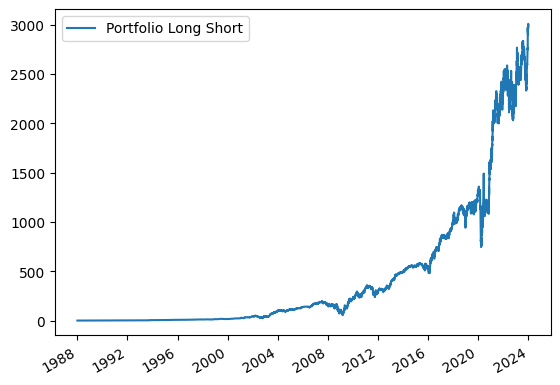

In [21]:
cum_returns = (1 + portfolio_long).cumprod()
cum_returns.plot()

In [22]:
mupor_long = portfolio_long.mean() * 252
mupor_long_short = portfolio_long_short.mean() * 252

sdpor_long = portfolio_long.std() * np.sqrt(252)
sdpor_long_short = portfolio_long_short.std() * np.sqrt(252)

srpor_long = mupor_long / sdpor_long
srpor_long_short = mupor_long_short / sdpor_long_short

print(f"Mu: {mupor_long[0]}")
print(f"Std: {sdpor_long[0]}")
print(f"Sharpe: {srpor_long[0]}")

print(f"Mu: {mupor_long_short[0]}")
print(f"Std: {sdpor_long_short[0]}")
print(f"Sharpe: {srpor_long_short[0]}")

Mu: 0.2546443862527876
Std: 0.25806296995279937
Sharpe: 0.9867529087933964
Mu: 0.04417223862836904
Std: 0.2195589434853223
Sharpe: 0.2011862415038538


/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/575143714.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Mu: {mupor_long[0]}")
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/575143714.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Std: {sdpor_long[0]}")
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/575143714.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

<Axes: >

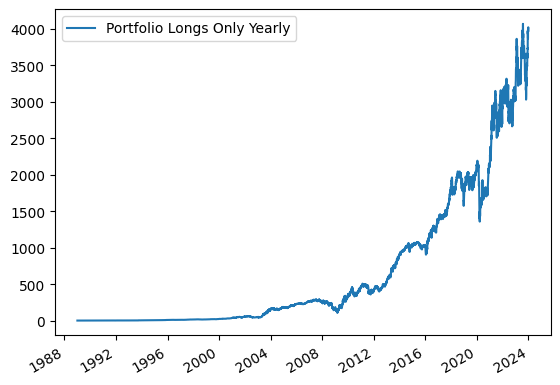

In [23]:
anual_cum_returns = (1 + portfolioanual_long).cumprod()
anual_cum_returns.plot()

In [24]:
mupor_year = portfolioanual_long.mean() * 252
sdpor_year = portfolioanual_long.std() * np.sqrt(252)
srpor_year = mupor_year / sdpor_year

print(f"Mu: {mupor_year[0]}")
print(f"Std: {sdpor_year[0]}")
print(f"Sharpe: {srpor_year[0]}")

Mu: 0.26570361555671745
Std: 0.24135515794607895
Sharpe: 1.1008822758040173


/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/1346682139.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Mu: {mupor_year[0]}")
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/1346682139.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Std: {sdpor_year[0]}")
/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_39488/1346682139.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc